# Initialization

In [406]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

plt.rc('figure', figsize=(8, 6))
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 125

In [168]:
import os

import numpy as np
import scipy as sp


# some constants
from numpy import pi

from scipy.special import erf
from scipy.linalg import solveh_banded
from scipy.interpolate import interp1d
from scipy.optimize import leastsq

import xarray as xr

In [161]:
# trig functions that take degrees

def sind(x):
    return np.sin(np.deg2rad(x))

def cosd(x):
    return np.cos(np.deg2rad(x))

In [3]:
gs = np.genfromtxt('RossbyZhang_figure2.csv', delimiter=',')
gs

array([[-1.1425960e+02, -2.0758000e-01],
       [-1.0402194e+02, -1.9165000e-01],
       [-9.3967090e+01, -1.7184000e-01],
       [-8.4643510e+01, -1.4430000e-01],
       [-7.4405850e+01, -9.7300000e-02],
       [-6.4168190e+01, -3.4760000e-02],
       [-5.4296160e+01,  5.8820000e-02],
       [-4.4789760e+01,  1.9900000e-01],
       [-3.4552100e+01,  4.1687000e-01],
       [-2.4680070e+01,  7.4347000e-01],
       [-1.3345520e+01,  1.2876000e+00],
       [-5.3016500e+00,  1.8005300e+00],
       [-3.1078600e+00,  1.9559600e+00],
       [-5.4845000e-01,  2.0492600e+00],
       [ 4.2047500e+00,  2.0261400e+00],
       [ 7.1298000e+00,  1.9563600e+00],
       [ 1.0420480e+01,  1.8477400e+00],
       [ 1.5173670e+01,  1.6692900e+00],
       [ 2.5411330e+01,  1.2968700e+00],
       [ 3.5283360e+01,  9.9434000e-01],
       [ 4.5521020e+01,  7.3843000e-01],
       [ 5.5393050e+01,  5.4464000e-01],
       [ 6.5265080e+01,  4.1298000e-01],
       [ 7.5502740e+01,  2.8134000e-01],
       [ 8.53747

This is Rossby and Zhang's fit

# With recirculation gyres

In [6]:
y = np.linspace(-125, 125, 201)
u_rz = np.piecewise(y, [y>=0, y<0], [
    lambda y: 2.61*np.exp(-y/25) - 0.33*np.exp(-y/3) - 0.23,
    lambda y: 2.75*np.exp( y/37) - 0.62*np.exp( y/3) - 0.08,    
])

Let us try to figure out what the profile should be using a functional form

$$\begin{aligned}
    u_1(y) &= c_1 e^{ y/L_1} + c_2 e^{ y/L_2} + c_3, \\
    u_2(y) &= c_4 e^{-y/L_3} + c_5 e^{-y/L_4} + c_6,     
\end{aligned}$$

where $u_1$ holds for $y < 0$ and $u_2$ holds for $y > 0$. Let us assume that the far field values and deformation radii given by Rossby and Zhang are correct, so $c_3 = u_- = -0.23$, $c_6 = u_+ = -0.08$, $L_1 = 25$, and $L_3 = 37$. If we require the peak velocity to be $u_0 = 2.05$ at $y = 0$, this gives

$$\begin{aligned}
    c_1 &= \frac{L_1}{L_1 - L_2}(u_0 - u_-), & c_2 &= -\frac{L_2}{L_1-L_2}(u_0 - u_-), \\
    c_4 &= \frac{L_3}{L_3 - L_4}(u_0 - u_+), & c_5 &= -\frac{L_4}{L_3-L_4}(u_0 - u_+).
\end{aligned}$$

We can therefore write the profile like

$$\begin{aligned}
    u_1(y) &= \frac{u_0 - u_-}{L_1 - L_2}\left(L_1 e^{ y/L_1} - L_2 e^{ y/L_2}\right) + u_-, \\
    u_2(y) &= \frac{u_0 - u_+}{L_3 - L_4}\left(L_3 e^{-y/L_3} - L_4 e^{-y/L_4}\right) + u_+.     
\end{aligned}$$


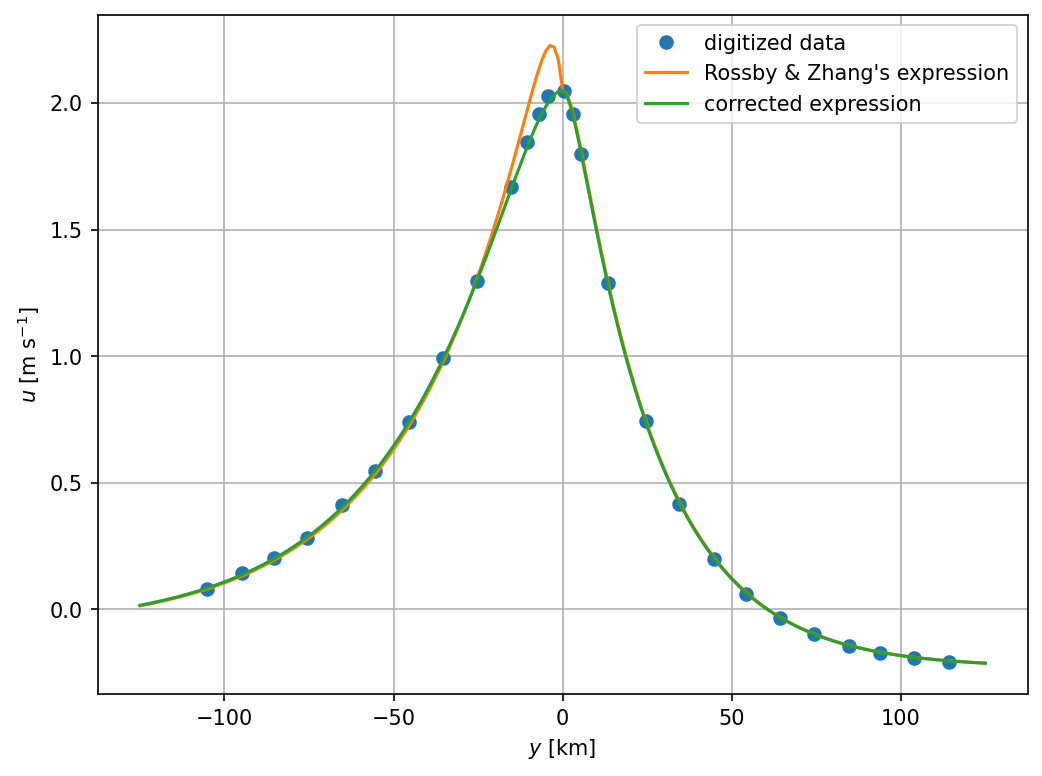

In [7]:
u0 = 2.05
um = -0.23
up = -0.08
L1 = 25
L3 = 37

L2 = 3
L4 = 9

u = np.piecewise(y, [y>=0, y<0], [
    lambda y: (u0 - um)/(L1 - L2)*(L1*np.exp(-y/L1) - L2*np.exp(-y/L2)) + um,
    lambda y: (u0 - up)/(L3 - L4)*(L3*np.exp( y/L3) - L4*np.exp( y/L4)) + up,
])

fig, ax = plt.subplots()

ax.plot(-gs[:,0], gs[:,1], 'o', label='digitized data')
ax.plot(y, u_rz, label="Rossby & Zhang's expression")
ax.plot(y, u, label='corrected expression')

ax.grid()
ax.legend()
ax.set_xlabel('$y$ [km]')
ax.set_ylabel('$u$ [m s$^{-1}$]')

fig.savefig('RossbyZhang.pdf', bbox_inches='tight')

# Without recirculation gyres

Text(0, 0.5, '$u$ [m s$^{-1}$]')

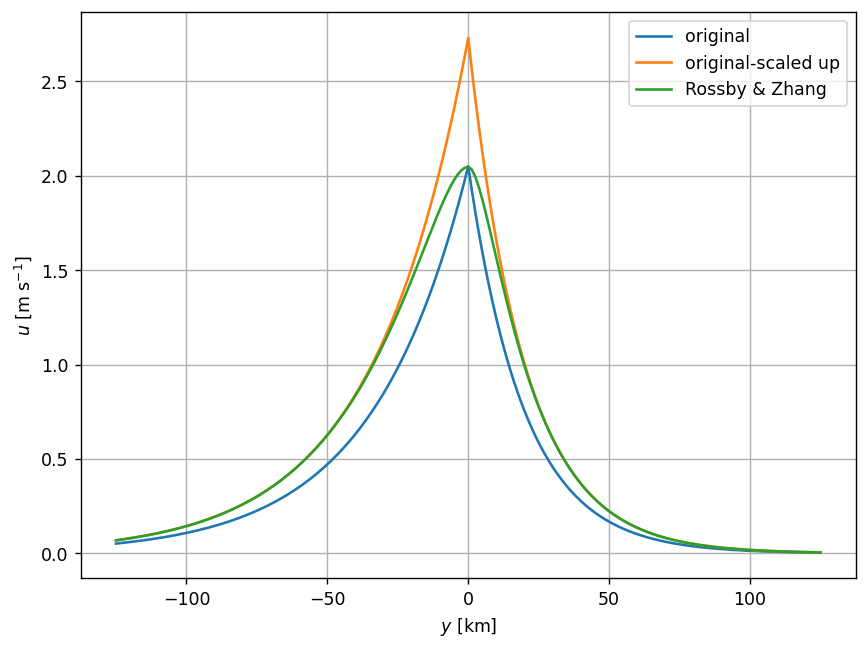

In [522]:
U0 = 2.73
L = 27
σ = 0.25
δ = 0.26

y = np.linspace(-125, 125, 201)

u_r = np.piecewise(y, [y <= 0, y>0], [
    lambda y: U0*(np.exp( y/(L*(1+δ))) - σ*np.exp( y/(σ*L*(1+δ)))),
    lambda y: U0*(np.exp(-y/(L*(1-δ))) - σ*np.exp(-y/(σ*L*(1-δ))))
])

u_ur = np.piecewise(y, [y <= 0, y>0], [
    lambda y: U0*np.exp( y/(L*(1+δ))),
    lambda y: U0*np.exp(-y/(L*(1-δ)))
])

fig, ax = plt.subplots()

ax.plot(y, (2.05/2.73)*u_ur, label="original")
ax.plot(y, u_ur, label="original-scaled up")
ax.plot(y, u_r, label="Rossby & Zhang")

ax.grid()
ax.legend()
ax.set_xlabel('$y$ [km]')
ax.set_ylabel('$u$ [m s$^{-1}$]')

# Smoothed front

Here we take the original Rossby-Zhang jet, calculate the PV, smooth it, and invert back to get the velocity and height.

## Parameters

The velocity, length scale, and asymmetric parameter come from Rossby and Zhang's "no recirculation" fit. The thermocline shoals by about 600 m. We adjust the mean depth to give an inverse Burger number that make the difference between the peaks near the front and the far field PV equal on both sides of the front.

In [548]:
# L = 2*27e3 # basic scale (twice the size for testing)
# U = 2.05/2 # max velocity (half the velocity for testing)
L = 27e3 # basic scale 
U = 2.73 # max velocity 
δ = 0.26 # asymmetry parameter
HS = 792.868 # southern thermocline depth
HN = 192.868 # northern thermocline depth
H = 5000 # maximum ocean depth
θ0 = 35 # central latitude
useBeta = True


# immutable physical parameters
Ω = 7.29e-5 # planetary rotation rate
a = 6378e3  # Earth radius
g = 9.8 # gravitational acceleration
rho0 = 1035 # Boussinesq reference density
km2m = 1000
    
# derived quantities
f0 = 2*Ω*sind(θ0) # Coriolis parameter
if useBeta:
    β = 2*Ω*cosd(θ0)/a # beta
else:
    β = 0
print('f0 = {:.3g}, β = {:.3g}'.format(f0, β))
    
H1 = (HS + HN)/2 # scale for thickness upper layer
ΔH = (HS - HN)/2 # change in thermocline depth across jet

# The reduced gravity is constrained the required velocity and depth change across the thermocline
gp = 1/(ΔH/(U*L*(f0 - 2*β*L*δ)) - 1/g) # reduced gravity

print('H1 = {:.1f},  gp = {:.3g}'.format(H1, gp))

# nondimensional parameters
F0 = f0**2*L**2/(g*H1)       # inverse Burger number for the free surface
F1 = f0**2*L**2/(gp*H1)      # inverse Burger number for the upper layer
F2 = f0**2*L**2/(gp*(H-H1))  # inverse Burger number for the lower layer
ε = U/(f0*L)                 # Rossby number
b = β*L/f0                   # beta number

print('F0 = {:.2g}, F1 = {:.3f}, F2 = {:.2g}'.format(F0, F1, F2))
print('ε = {:.2f}, b = {:.2g}'.format(ε, b))

f0 = 8.36e-05, β = 1.87e-11
H1 = 492.9,  gp = 0.0205
F0 = 0.0011, F1 = 0.504, F2 = 0.055
ε = 1.21, b = 0.006


## Horizontal grid

In [549]:
y0 = 0
Ly = 1000      # meridional extent
dx = 1.0 

ys = -Ly/2
yn =  Ly/2

yq = np.arange(ys, yn+dx, dx)
yh = np.arange(ys+dx/2, yn, dx)

NY = len(yh)

grid = xr.Dataset({}, coords={
    'yq': (['yq'], yq),
    'yh': (['yh'], yh),
})
grid

fh = f0 + β*grid.yh*km2m
fq = f0 + β*grid.yq*km2m

In [550]:
η1 = -H1 - L*U/gp*xr.where(grid.yh <= 0, 
                   +f0 - 2*β*L*δ - (1+δ)*(fh - β*L*(1+δ))*np.exp(+grid.yh*km2m/(L*(1+δ))),
                   -f0 + 2*β*L*δ + (1-δ)*(fh + β*L*(1-δ))*np.exp(-grid.yh*km2m/(L*(1-δ))),
                   ) 


h1 = -η1

u1 = U*xr.where(grid.yh <= 0, 
                np.exp( grid.yh*km2m/(L*(1+δ))),
                np.exp(-grid.yh*km2m/(L*(1-δ))),
               )

ζ1 = -(U/L)*xr.where(grid.yh <= 0, 
                 np.exp( grid.yh*km2m/(L*(1+δ)))/(1+δ),
                -np.exp(-grid.yh*km2m/(L*(1-δ)))/(1-δ),
               )

q1 = (fh + ζ1)/h1

In [559]:
def smoothed_front(y, q, d, HS, HN, gp, fh, fq):
    '''
    Smooth a pv distribution and compute u and h from that smoothed distribution.
    
    Parameters
    ----------
    y : array-like
        y coordiantes in km
    q : array-like
        PV distributions
    d : float
        Smoothing scale in km
        
    returns
    -------
    q : ndarray
        smoothed PV
    h : ndarray
        Thickness
    u : ndarray
        Velocity
    '''
    NY = len(y)
    dy = (y[1]-y[0])*1000
    
    if d == 0:
        hflt = np.array([1])
    else:
        hflt = np.exp(-y**2/d**2)        
        hflt /= hflt.sum()
    
    qtmp = np.zeros(3*NY)
    qtmp[:NY] = float(q[0])
    qtmp[NY:2*NY] = q
    qtmp[2*NY:] = float(q[-1])
    qs = np.convolve(hflt, qtmp, mode='same')[NY:2*NY]
    
    # The matrix ab is stored in the "lower" form where the first row is the main diagonal and the second row is the 
    # lower diagonal
    ab = np.zeros((2, NY))
    ab[0,:] = 1/fq[1:] + 1/fq[:-1] + dy**2*qs/gp
    ab[1,:] = -1/fq[1:]

    rhs = fh*dy**2/gp
    rhs[ 0] += HS/fq[ 0]
    rhs[-1] += HN/fq[-1]

    h = solveh_banded(ab, rhs, overwrite_ab=True, overwrite_b=True, lower=True)
    u = np.zeros(NY)
    u[0]    = -gp*(h[1] - HS)/(2*dy)/fh[0]
    u[1:-1] = -gp*(h[2:] - h[:-2])/(2*dy)/fh[1:-1]
    u[-1]   = -gp*(HN - h[-2])/(2*dy)/fh[-1]

    return qs, h, u



In [551]:
qs, hs, us = smoothed_front(grid.yh.values, q1.values, 15, HS, HN, gp, fh.values, fq.values)

(-125.0, 125.0)

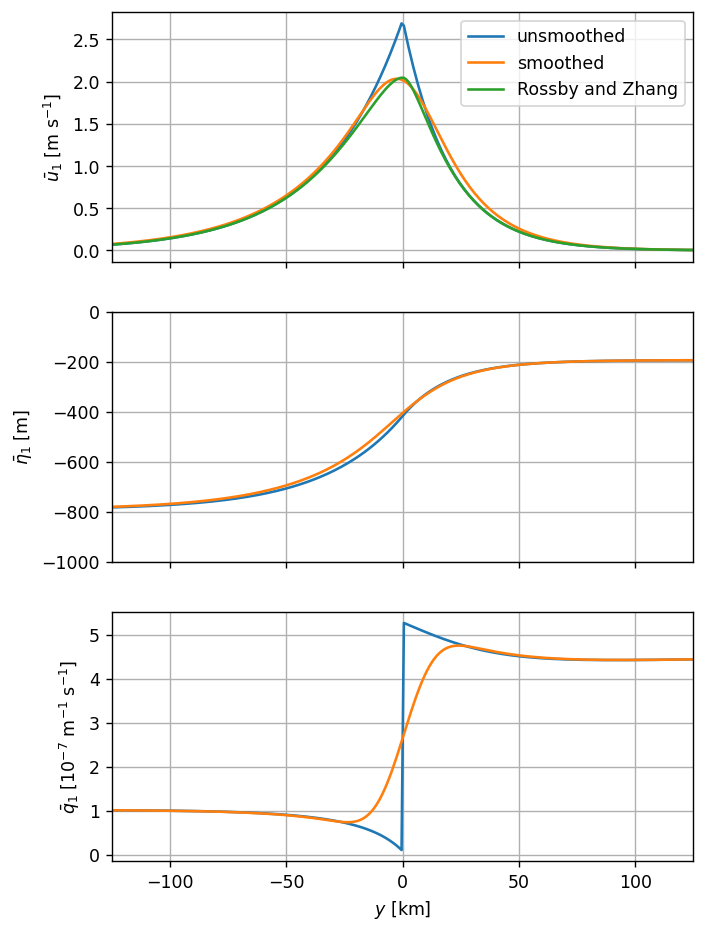

In [554]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(6,9))

y0 = float(grid.yh[np.argmax(us)])

σ = 0.25

y = grid.yh.values*km2m
u_r = np.piecewise(y, [y <= 0, y>0], [
    lambda y: U*(np.exp( y/(L*(1+δ))) - σ*np.exp( y/(σ*L*(1+δ)))),
    lambda y: U*(np.exp(-y/(L*(1-δ))) - σ*np.exp(-y/(σ*L*(1-δ))))
])

ax = axs[0]
ax.plot(grid.yh, u1, label='unsmoothed')
ax.plot(grid.yh - y0/2, us, label='smoothed')
ax.plot(grid.yh, u_r, label='Rossby and Zhang')
# ax.plot(-gs[:,0], gs[:,1], 'o', markersize=4, label=)
ax.legend()
ax.grid()
ax.set_ylabel(r'$\bar{u}_1$ [m s$^{-1}$]')

ax = axs[1]
ax.plot(grid.yh, η1)
ax.plot(grid.yh, -hs)
ax.grid()
ax.set_ylabel(r'$\bar{\eta}_1$ [m]')
ax.set_ylim(-1000, 0)

ax = axs[2]
ax.plot(grid.yh, 1e7*q1)
ax.plot(grid.yh, 1e7*qs)
ax.grid()
ax.set_ylabel(r'$\bar{q}_1$ [$10^{-7}$ m$^{-1}$ s$^{-1}$]')
ax.set_xlabel('$y$ [km]')
ax.set_xlim(-125, 125)


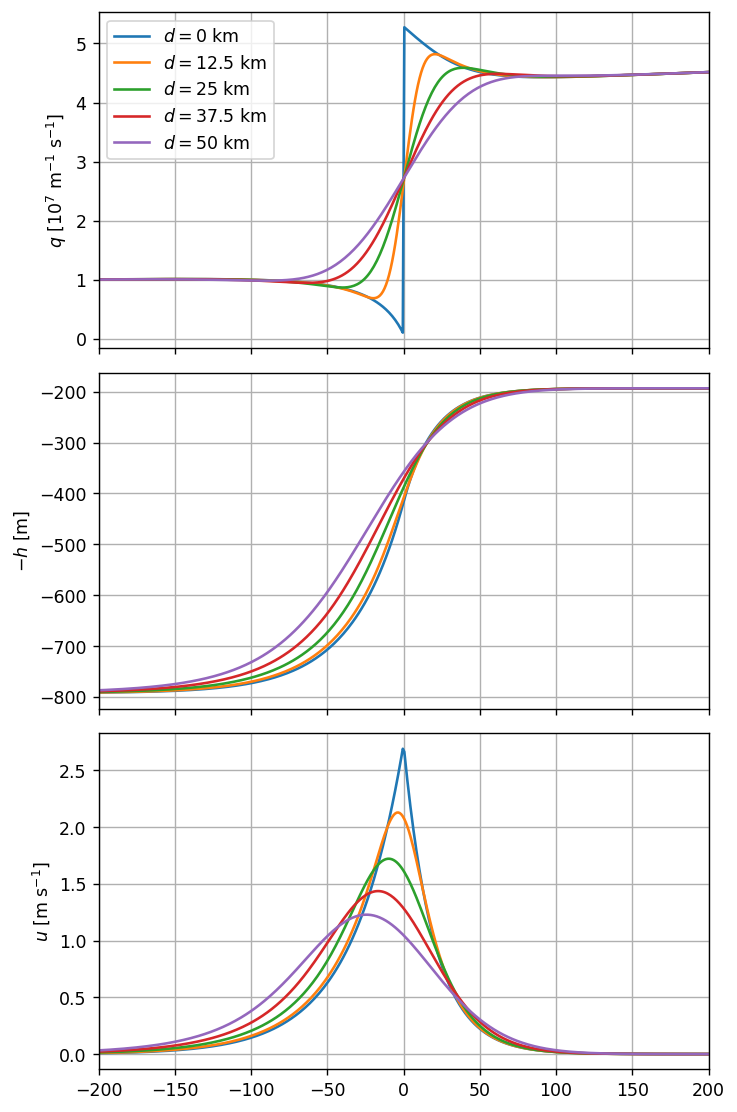

In [563]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(6,9))

dmax = 50

for d in np.linspace(0, dmax, 5):
    qs, hs, us = smoothed_front(grid.yh.values, q1.values, d, HS, HN, gp, fh.values, fq.values)
    
    ax = axs[0]
    ax.plot(grid.yh, 1e7*qs, label='$d = {:g}$ km'.format(d))
    
    ax = axs[1]
    ax.plot(grid.yh, -hs)
    
    ax = axs[2]
    ax.plot(grid.yh, us)
    
for ax in axs:
    ax.grid()
    
axs[0].legend()
axs[0].set_ylabel('$q$ [$10^{7}$ m$^{-1}$ s$^{-1}$]')
axs[1].set_ylabel('$-h$ [m]')
axs[2].set_ylabel('$u$ [m s$^{-1}$]')
axs[2].set_xlim(-200, 200)

fig.tight_layout()